This notebook contains code to generate a set of conformers useful for the biaryl torsional scan. The rotamers are built using RDKit. 

Cal notar que 
- La starting structure ve de rdkit a partir de l'smiles i NO està optimitzada [afectarà als results]. Cal fer càlculs amb el gaussian. 
- Els confòrmers no es relaxen, es fa single point calculations. 
- Conversió d'unitats entre MACE-OFF i MACE-MP



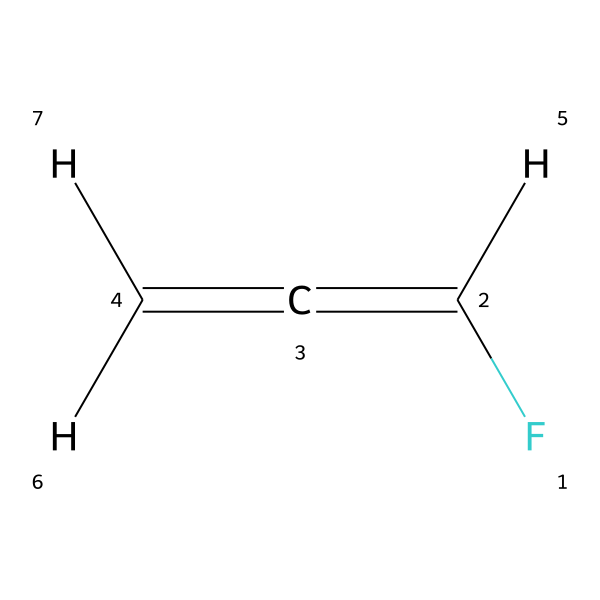

1


"\nprint('modified bond distance')\nprint(rdMolTransforms.GetBondLength(conf, 9, 8))\nrdMolTransforms.SetBondLength(conf, 9, 8, 3.)\nprint(rdMolTransforms.GetBondLength(conf, 9, 8))\nIPythonConsole.drawMol3D(tmol, confId=0)\n\nprint('modified angle')\nprint(rdMolTransforms.GetAngleDeg(conf, 9, 8, 10))\nrdMolTransforms.SetAngleDeg(conf, 9,  8, 10, 90)\nprint(rdMolTransforms.GetAngleDeg(conf, 9, 8, 10))\nIPythonConsole.drawMol3D(tmol, confId=0)\n"

In [1]:
# general imports
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import rdDepictor
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import IPythonConsole

# rdkit display options [jupyter notebook]
IPythonConsole.ipython_3d = True
IPythonConsole.molSize = (600, 600)   
IPythonConsole.ipython_useSVG = True

# define the molecule
esomeprazole = Chem.MolFromSmiles('FC=C=C')
esomeprazole = Chem.AddHs(esomeprazole)

# add numbering and display it 
for atom in esomeprazole.GetAtoms():
    atom.SetProp('atomNote', str(atom.GetIdx()+1))
display(esomeprazole)

# create a new molecule
rdDistGeom.EmbedMolecule(esomeprazole)
tmol = Chem.Mol(esomeprazole)
print(tmol.GetNumConformers())
tmol.GetConformer().Set3D(True)


#================================#
#       DIHEDRAL DEFINITIONS     #
#================================#

# define the dihedral
dihedral_numbers = [0, 1, 2, 3]

# define the resolution of the dihedral scan
# resolucó multiple de 360
# resolution {4, 6, 9, 18, 36, 72, etc} + 1
resolution = 72 + 1

# whether to visualize the conformers
vis = False

# bifenil 5 4 7 8
# C1=CC=C(C=C1)C2=CC=CC=C2

# structure 25
# C1=CC(=O)NC(=C1)C2=CC=CO2
# 5 6 8 9 --> (0 base indexing) 4 5 7 8
# faig servir 5 6 8 12 per fer-ho com a la referència

# structure 76
# C1=CNC2=NC=NC(=C21)C3=CNN=C3
# 7 8 10 11 --> 6, 7, 9, 10
# 9 8 10 11 --> 8, 7, 9, 10
# 7 8 10 14 --> 6, 7, 9, 13

# structure 23
# C1=CC(=O)NC(=C1)C2=COC=C2
# 5 6 8 9 --> 4, 5, 7, 8

# ethane
# CC
# 4 1 2 8 --> 3, 0, 1, 7

# allene 
# FC=C=C
# 1 2 3 4 --> 0, 1, 2, 3

'''
# ask and modify bonds, angles and dihedrals

print(tmol.GetNumConformers(), tmol.GetConformer().Is3D())
print([x.GetId() for x in tmol.GetConformers()])


print('initial conformer')
conf = tmol.GetConformer(0)
#rdMolTransforms.CanonicalizeConformer(conf)
IPythonConsole.drawMol3D(tmol, confId=0)
'''
'''
print('modified bond distance')
print(rdMolTransforms.GetBondLength(conf, 9, 8))
rdMolTransforms.SetBondLength(conf, 9, 8, 3.)
print(rdMolTransforms.GetBondLength(conf, 9, 8))
IPythonConsole.drawMol3D(tmol, confId=0)

print('modified angle')
print(rdMolTransforms.GetAngleDeg(conf, 9, 8, 10))
rdMolTransforms.SetAngleDeg(conf, 9,  8, 10, 90)
print(rdMolTransforms.GetAngleDeg(conf, 9, 8, 10))
IPythonConsole.drawMol3D(tmol, confId=0)
'''


In [2]:
#===================================#
#       CONFORMER DEFINITION        #
#===================================#

conf = Chem.Conformer(tmol.GetConformer(0))
rdMolTransforms.CanonicalizeConformer(conf)

cp = Chem.Mol(tmol)
rdDepictor.Compute2DCoords(cp)
cp.RemoveConformer(0)
dihedral_list = np.linspace(0., 360., resolution)

real_dihedral_list = []

print(f'initial conformers\t{cp.GetNumConformers()}\t(should be 0)')
print(f'{360/(resolution-1):.0f} deg dihedral scan resolution\n{len(dihedral_list)} single point calculations')

# generate the conformers
for i in range(len(dihedral_list)):

    rdMolTransforms.SetDihedralDeg(conf, dihedral_numbers[0], dihedral_numbers[1], dihedral_numbers[2], dihedral_numbers[3], dihedral_list[i])
    real_dihedral_list.append(rdMolTransforms.GetDihedralDeg(conf, dihedral_numbers[0], dihedral_numbers[1], dihedral_numbers[2], dihedral_numbers[3]))
    cp.AddConformer(conf,assignId=True)
    
    if vis:
        IPythonConsole.drawMol3D(cp, confId=i) 
    
    print(f'{rdMolTransforms.GetDihedralDeg(conf, dihedral_numbers[0], dihedral_numbers[1], dihedral_numbers[2], dihedral_numbers[3]):.2f}\t\tdeg conformer generated')
print(f'finished generating {len(dihedral_list)} conformers')


#===============================#
#   save all conformers to xyz  #
#===============================#

# working directory
save_dir = './'

# save the paths created
saved_conf_list = []

# write .xyz for each conformer
for cid in range(cp.GetNumConformers()):
    with open(os.path.join(save_dir, f'conformer_{cid}.xyz'), 'w') as file:
        file.write(f"{cp.GetNumAtoms()}\n")
        file.write('Generated by Sergi\n')

        for atom in cp.GetAtoms():
            coords = cp.GetConformer(cid).GetAtomPosition(atom.GetIdx())
            file.write(f"{atom.GetSymbol()}\t{coords.x:.9f}\t{coords.y:.9f}\t{coords.z:.9f}\n")

    saved_conf_list.append(f'conformer_{cid}.xyz')


'''
# save all conformers to file
writer = Chem.SDWriter('conformers.sdf')
for cid in range(cp.GetNumConformers()):
    cp.SetProp('ID', f'conformer_{cid}')
    writer.write(cp, confId=cid)
'''

'''
# save all conformers to file
writer = Chem.rdmolfiles.PDBWriter('conformers.pdb')
for cid in range(cp.GetNumConformers()):
    cp.SetProp('ID', f'conformer_{cid}')
    writer.write(cp, confId=cid)
'''

#===============================#
#   save all conformers to pdb  #
#===============================#

'''
# save the paths created
saved_conf_list = []

for cid in range(cp.GetNumConformers()):
    Chem.rdmolfiles.MolToPDBFile(cp, os.path.join(save_dir, f'conformer_{cid}.pdb'), confId=cid)
    saved_conf_list.append(f'conformer_{cid}.pdb')

print(saved_conf_list)
'''

with open(os.path.join(save_dir, 'conformer_info.txt'), 'w+') as f:
    for file, angle in zip(saved_conf_list, dihedral_list):
        f.write(f'{file}\t{angle}\n')


initial conformers	0	(should be 0)
5 deg dihedral scan resolution
73 single point calculations
0.00		deg conformer generated
5.00		deg conformer generated
10.00		deg conformer generated
15.00		deg conformer generated
20.00		deg conformer generated
25.00		deg conformer generated
30.00		deg conformer generated
35.00		deg conformer generated
40.00		deg conformer generated
45.00		deg conformer generated
50.00		deg conformer generated
55.00		deg conformer generated
60.00		deg conformer generated
65.00		deg conformer generated
70.00		deg conformer generated
75.00		deg conformer generated
80.00		deg conformer generated
85.00		deg conformer generated
90.00		deg conformer generated
95.00		deg conformer generated
100.00		deg conformer generated
105.00		deg conformer generated
110.00		deg conformer generated
115.00		deg conformer generated
120.00		deg conformer generated
125.00		deg conformer generated
130.00		deg conformer generated
135.00		deg conformer generated
140.00		deg conformer generated

In [1]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.io import read
from ase.io import trajectory

In [2]:
# funció per avaluar les energies, d'un conformer de moment. 

def evaluate_conformers(conformer_file, calculator_list, save_dir='./'):
    '''
    evaluate a set of conformations (single point calculations)
    '''


    if save_dir is None:
        save_dir = './'

    # read the conformer_info.txt file
    # extract both directories and dihedral angles

    dih_list = []
    conf_list = []

    with open(conformer_file, 'r') as file:
        
        print(f'reading {conformer_file}')
        for line in file:
            file_id, angle_id = line.strip().split('\t')
            dih_list.append(float(angle_id))
            conf_list.append(file_id)

    print(f'{len(conf_list)} conformation files fetched')
    print(f'{len(dih_list)} dihedrals fetched')
 
    # save the conformations to a list
    #conf_atoms_list = []
    #for file in conf_list:
    #    conf_atoms_list.append(read(file))

    #view(conf_atoms_list[3], viewer='ase')

    if len(calculator_list) == 1:
        traj_path = os.path.join(save_dir, 'dihedral_scan.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')


    # use the calculator to compute the conformational energies
    # dimensiton [num_calc, num_conf]
    energies = []

    for calc_ in calculator_list:

        temp_list = []

        for i in range(len(conf_list)):

            atoms = read(conf_list[i])
            atoms.calc = calc_
            energy_conf = atoms.get_potential_energy()
            temp_list.append(energy_conf)

            if len(calculator_list) == 1:
                traj.write(atoms)


        energies.append(temp_list)

        if len(calculator_list) == 1:
            traj.close()
    
    return dih_list, energies




def plot_dihedral(dihedral_list, energy_list, calculator_names, calculator_colors, dihedral_name='', save_dir=None):
    '''
    Plot a dihedral scan. 
    '''

    if save_dir is None:
        save_dir = './'

    _color_list = ['black', 'red', 'orange', 'blue']
    _marker_list = ['^', 'd', 'v', 'o']

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7,4)) 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):
        
        # gather the minimum energy structure
        idx = np.argmin(energy_list[k][:])
        min_energy = energy_list[k][idx]
        min_dih = dihedral_list[idx]

        # TODO convert energy from eV/particle to kcal/mol: 1 eV/molecule = 23.0605 kcal/mol

        axes.plot(dihedral_list, (np.array(energy_list[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)
        axes.scatter(min_dih, min_energy-min_energy, color=_color_list[k], marker=_marker_list[k], label=r'$\textnormal{reference dihedral at ' + f'{min_dih:.0f}' + r' deg}$')

    axes.set(xlabel=r'$\textnormal{' + f'{dihedral_name}' + r' dihedral angle}\;\textnormal{(deg)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(kcal/mol)}$')
    axes.legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{dihedral_name}'+'dihedral_PES.png'), dpi=300)
    plt.show(fig)

In [3]:
#=======================#
#       CALCULATOR      #
#=======================#

from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

#calculator_list = [macemp, maceoff]
#calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['darkgreen', 'deeppink']

calculator_list = [maceoff]
calculator_names = ['MACE-OFF']

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


reading ./conformer_info.txt
73 conformation files fetched
73 dihedrals fetched


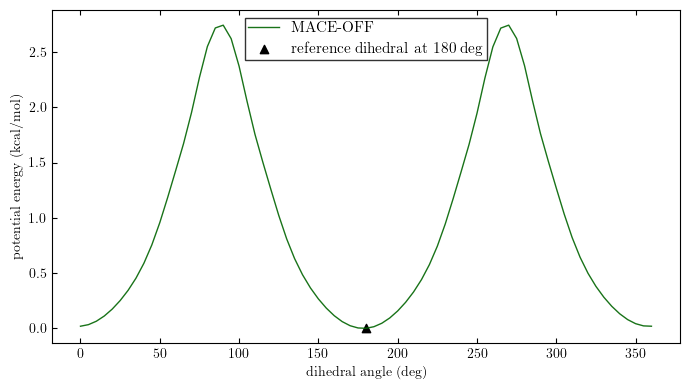

In [4]:
# path to the conformation directory
info_path = os.path.join('./', 'conformer_info.txt')

# evaluate the conformations
dihedrals, energies = evaluate_conformers(info_path, calculator_list, save_dir='./')
plot_dihedral(dihedrals, energies, calculator_names, calculator_colors, dihedral_name='', save_dir=None)

In [5]:
traj = trajectory.TrajectoryReader('./dihedral_scan.traj')
view(traj, viewer='ngl')